In [1]:
import pandas_datareader.data as web
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hmmlearn import hmm





In [2]:

df=pd.read_excel(r'/Users/devanshjoshi/Desktop/KOTAK/Data_Nifty.xlsx')
dates=df['Date']
x=df['Close']
x=x.to_numpy()


In [3]:
high=x[0]
low=x[0]
returns=[]
tmv=[]
threshold=0.056
time=0
up=0
down=0
dc=0
time_high=0
time_low=0
first_time=0
for i in range(1,len(x)):
    time=time+1
    if(up==0 and down==0):
        if(x[i]>=(1+threshold)*high):
            up=1
            down=0
            high=x[i]
            time_high=time
            first_time=time
        elif(x[i]<=(1-threshold)*low):
            down=1
            up=0
            low=x[i]
            time_low=time
            first_time=time
        else:
            pass
    elif(up==1 and dc==0):
        if(x[i]>=(1+threshold)*high):
            up=1
            down=0
            high=x[i]
            time_high=time
        elif(x[i]<=(1-threshold)*high):
            dc=1
            down=1
            up=0
            low=x[i]
            time_low=time
        else:
            pass
    elif(down==1 and dc==0):
        if(x[i]<=(1-threshold)*low):
            up=0
            down=1
            low=x[i]
            time_low=time
        elif(x[i]>=(1+threshold)*low):
            dc=1
            down=0
            up=1
            high=x[i]
            time_high=time
        else:
            pass
    elif(up==1 and dc==1):
        if(x[i]>=(1+threshold)*high):
            up=1
            down=0
            high=x[i]
            time_high=time
        elif(x[i]<=(1-threshold)*high):

            
            t_bw_trend=abs(time_high-time_low)
            r=[abs((low-high)/(low*t_bw_trend))]*t_bw_trend
            tm=[(high-low)/(low*threshold)]*t_bw_trend

            returns.extend(r)
            tmv.extend(tm)
            low=x[i]
            time_low=time
            up=0
            down=1
        else:
            pass
    elif(down==1 and dc==1):
        if(x[i]<=(1-threshold)*low):
            up=0
            down=1
            low=x[i]
            time_low=time
        elif(x[i]>=(1+threshold)*low):

            t_bw_trend=abs(time_high-time_low)
            r=[abs((low-high)/(high*t_bw_trend))]*t_bw_trend
            tm=[(low-high)/(high*threshold)]*t_bw_trend

            returns.extend(r)
            tmv.extend(tm)
            high=x[i]
            time_high=time
            up=1
            down=0
        else:
            pass
    else:
        pass
     
    
    
        

In [4]:
buffer_beginning=[returns[0]]*first_time
returns.extend(buffer_beginning)
buffer_end=[returns[len(returns)-1]]*(time-(len(returns)-1))
returns.extend(buffer_end)

returns=np.array(returns)

buffer_beginning=[tmv[0]]*first_time
tmv.extend(buffer_beginning)
buffer_end=[tmv[len(tmv)-1]]*(time-(len(tmv)-1))
tmv.extend(buffer_end)

tmv=np.array(tmv)


Returns


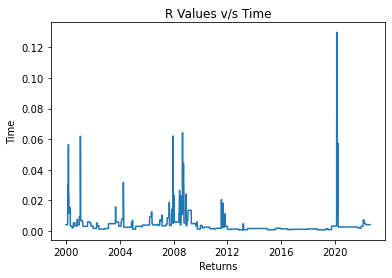

In [5]:
print("Returns")
plt.figure()
plt.title('R Values v/s Time')
plt.xlabel('Returns')
plt.ylabel('Time')
plt.plot(dates,returns)
plt.show()



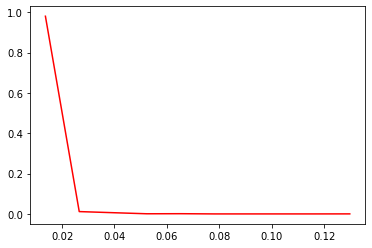

In [6]:
plt.figure()
count, bins_count = np.histogram(returns, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.show()

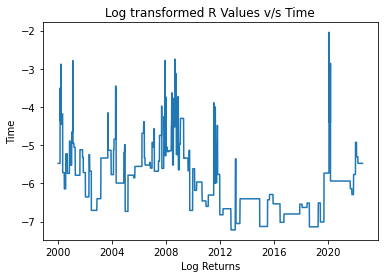

In [7]:

for i in range(len(returns)):
    returns[i]=math.log(returns[i])

plt.figure()
plt.title('Log transformed R Values v/s Time')
plt.xlabel('Log Returns')
plt.ylabel('Time')
plt.plot(dates,returns)
plt.show()
df['Returns']=returns
df['TMV']=tmv



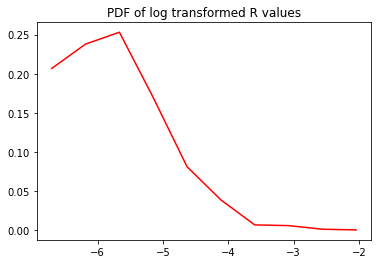

In [8]:
plt.figure()
count, bins_count = np.histogram(df["Returns"], bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.title('PDF of log transformed R values')
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.show()



In [9]:

df['Regime']=" "
df["D_ret"]=' '
df["D_ret"]=df["Close"].pct_change()
df["22_ret"]=df["Close"].pct_change(22)
df["66_ret"]=df["Close"].pct_change(66)
df["Vol"]=df["Close"].pct_change().rolling(22).std()
df=df.dropna()
# df.head()


In [10]:
print(df.corr())

            Close   Returns       TMV     D_ret    22_ret    66_ret       Vol
Close    1.000000 -0.297049  0.152081  0.007142  0.031772  0.053608 -0.290944
Returns -0.297049  1.000000  0.043350 -0.015009 -0.018746  0.015912  0.470220
TMV      0.152081  0.043350  1.000000  0.032051  0.100906  0.123882 -0.002935
D_ret    0.007142 -0.015009  0.032051  1.000000  0.206941  0.118603  0.006819
22_ret   0.031772 -0.018746  0.100906  0.206941  1.000000  0.558616 -0.299510
66_ret   0.053608  0.015912  0.123882  0.118603  0.558616  1.000000 -0.295492
Vol     -0.290944  0.470220 -0.002935  0.006819 -0.299510 -0.295492  1.000000


In [11]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
X_train=df.loc[(df['Date'] < '2003-04-30')]
X=X_train.loc[:,["Returns","22_ret","66_ret","Vol"]] 
print(X.corr())





          Returns    22_ret    66_ret       Vol
Returns  1.000000 -0.195371 -0.135691  0.478316
22_ret  -0.195371  1.000000  0.454675 -0.436338
66_ret  -0.135691  0.454675  1.000000 -0.444789
Vol      0.478316 -0.436338 -0.444789  1.000000


In [12]:
from scipy.stats import poisson
scores = list()
models = list()
for n_components in range(1, 5):
    for idx in range(10):
        model = hmm.GaussianHMM(n_components=n_components, random_state=idx)
        model.fit(X)
        models.append(model)
        scores.append(model.score(X))
model = models[np.argmax(scores)]


In [ ]:
list_of_predictions=[]
mstd=[]
from datetime import datetime
from dateutil import rrule

start_date = datetime(2003, 5, 31)
end_date = datetime(2022, 7, 31)
# t=model.transmat_
# m=model.means_
# c=model.covars_
pd.options.mode.chained_assignment = None

from dateutil.relativedelta import relativedelta
dt=start_date
while(dt<end_date+relativedelta(days=1)):
    X_train=df.loc[(df['Date'] <= dt)]
    dates=X_train["Date"]
    X=X_train.loc[:,["Returns","22_ret","66_ret","Vol"]]
    scores = list()
    models = list()
    for n_components in range(4,5):
        for idx in range(1):
            model = hmm.GaussianHMM(n_components=n_components,init_params="s", random_state=idx)
#             model.transmat_ = t
#             model.means_ = m
#             model.covars_ = np.array([np.diag(i) for i in c])
            model.fit(X)
            models.append(model)
            scores.append(model.score(X))
    model = models[np.argmax(scores)]
#     t=model.transmat_
#     m=model.means_
#     c=model.covars_
    pred=model.predict(X)
    X_train["Regime"]=pred
    X_train["Regime"]=X_train['Regime'].shift(1)
    X_train["D_ret"]=' '
    X_train["D_ret"]=X_train["Close"].pct_change()
    MEAN=X_train[["Regime", "D_ret"]].groupby("Regime").mean()
    STD=X_train[["Regime", "D_ret"]].groupby("Regime").std()
    list_of_predictions.append((dates,pred))
    mstd.append((MEAN,STD))
    dt=dt+relativedelta(months=1)

    




In [ ]:
excel=pd.DataFrame()
col=0
for i in range(0,len(list_of_predictions)):
    df_add=pd.DataFrame()
    df_mstd=pd.DataFrame()
    df_rank=pd.DataFrame()
    df_add[str(col)]=list_of_predictions[i][0]
    col=col+1
    df_add["Pred"]=list_of_predictions[i][1]
    col=col+1
    df_mstd["Mean"]=mstd[i][0]["D_ret"].to_numpy()
    df_mstd["STD"]=mstd[i][1]["D_ret"].to_numpy()
    df_mstd["Vals"]=df_mstd["Mean"]/df_mstd["STD"]
    nums=np.array([0,1,2,3])
    df_mstd["Regime"]=nums
    df_mstd=df_mstd.sort_values(by=["Vals"]).reset_index(drop=True)
    df_rank["Rank"]=df_mstd["Regime"]
    dict_map = {df_rank["Rank"][0]:'WORST' ,  df_rank["Rank"][1]:'SECOND WORST', df_rank["Rank"][2]:'SECOND BEST', df_rank["Rank"][3]:'BEST'}
    df_add["Pred"] = df_add["Pred"].map(dict_map)
    excel = pd.concat([excel, df_add], axis=1)
    


excel.to_excel("/Users/devanshjoshi/Desktop/output1.xlsx")

    

    